## Evaluating the `AnasAlokla/multilingual_go_emotions` model

this code is same eval_roberta_base_go_emotions code
with some differant

In [2]:
%%capture
!pip install datasets transformers pandas matplotlib tqdm --upgrade --quiet

In [3]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Load the dataset

We just want the dataset test split here for evaluation

In [4]:
split_name = "test"

dataset_name = "AnasAlokla/multilingual_go_emotions"
dataset_dict = datasets.load_dataset(dataset_name)
#dataset = load_dataset('AnasAlokla/multilingual_go_emotions')
dataset_dict[split_name][0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/523 [00:00<?, ?B/s]

train_dataset.csv:   0%|          | 0.00/27.4M [00:00<?, ?B/s]

validation_dataset.csv:   0%|          | 0.00/3.44M [00:00<?, ?B/s]

test_dataset.csv:   0%|          | 0.00/3.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/260460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/32556 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/32562 [00:00<?, ? examples/s]

{'text': "Haha ouais. Merci. C'est réglé\xa0!",
 'labels': '[1, 15]',
 'id': 'FRee1a6me',
 'language': 'fr'}

In [5]:
# prompt: update the labels in dataset_dict convert from string like '[1, 15]' to normal list [1,15]

import ast

def convert_labels(example):
    example['labels'] = ast.literal_eval(example['labels'])
    # Check if 'text' is None and remove the example if it is
    return example if example['text'] is not None else None

# Apply the function to convert labels and filter out examples with None text
dataset_dict = dataset_dict.map(convert_labels, remove_columns=None)

# Drop examples where the map function returned None
for split_name in dataset_dict:
    if hasattr(dataset_dict[split_name], 'filter'):
        dataset_dict[split_name] = dataset_dict[split_name].filter(lambda x: x is not None)

# Check a sample
dataset_dict[split_name][0]


Map:   0%|          | 0/260460 [00:00<?, ? examples/s]

Map:   0%|          | 0/32556 [00:00<?, ? examples/s]

Map:   0%|          | 0/32562 [00:00<?, ? examples/s]

Filter:   0%|          | 0/260448 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32544 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32556 [00:00<?, ? examples/s]

{'text': "Haha ouais. Merci. C'est réglé\xa0!",
 'labels': [1, 15],
 'id': 'FRee1a6me',
 'language': 'fr'}

In [6]:
labels_name=[
          "admiration",
          "amusement",
          "anger",
          "annoyance",
          "approval",
          "caring",
          "confusion",
          "curiosity",
          "desire",
          "disappointment",
          "disapproval",
          "disgust",
          "embarrassment",
          "excitement",
          "fear",
          "gratitude",
          "grief",
          "joy",
          "love",
          "nervousness",
          "optimism",
          "pride",
          "realization",
          "relief",
          "remorse",
          "sadness",
          "surprise",
          "neutral"
        ]

In [7]:
labels = labels_name
print({i: l for i, l in enumerate(labels)})

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


Load into a `y_target` stucture of arrays by label (since we wish to evaluate per label for a multi-label, multi-class dataset like this)

In [8]:
num_items, num_labels = len(dataset_dict[split_name]), len(labels)
y_targets_all = np.zeros((num_items, num_labels), dtype=int)
for i, labels_indices in enumerate(dataset_dict[split_name]["labels"]):
    for label_index in labels_indices:
        y_targets_all[i, label_index] = 1

print(y_targets_all[0:3])

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Load the model and run it

Loading in a multi-label, multi-class classifier model based on Roberta-base

In [9]:
model_name='AnasAlokla/multilingual_go_emotions'
classifier = pipeline(task="text-classification", model=model_name, top_k=None, truncation=True, max_length=128)

config.json:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


Very simple to then run the pipeline on the dataset test split.
- c.5k items so can be run on a decent CPU in a few minutes (E.g. 3.5 mins on a 11th gen i7 laptop)
- (will take signifcantly longer on a free Colab instance's 2 core CPU)
- or of course via a GPU in seconds.

In [10]:

model_outputs = classifier(dataset_dict[split_name]["text"][0])

print(dataset_dict[split_name]["text"][0])
print(model_outputs[0])

text1='انا سعيد جداً'
model_outputs = classifier(text1)

print(text1)
print(model_outputs)

Haha ouais. Merci. C'est réglé !
[{'label': 'gratitude', 'score': 0.948058009147644}, {'label': 'amusement', 'score': 0.39725184440612793}, {'label': 'joy', 'score': 0.02780122682452202}, {'label': 'approval', 'score': 0.01285602431744337}, {'label': 'neutral', 'score': 0.01262691617012024}, {'label': 'optimism', 'score': 0.011523596942424774}, {'label': 'admiration', 'score': 0.010046065784990788}, {'label': 'realization', 'score': 0.00984946545213461}, {'label': 'curiosity', 'score': 0.008166581392288208}, {'label': 'annoyance', 'score': 0.008126690983772278}, {'label': 'confusion', 'score': 0.00798523984849453}, {'label': 'disapproval', 'score': 0.007851085625588894}, {'label': 'relief', 'score': 0.007259519305080175}, {'label': 'anger', 'score': 0.006232301238924265}, {'label': 'sadness', 'score': 0.0061301616951823235}, {'label': 'caring', 'score': 0.0057256268337368965}, {'label': 'desire', 'score': 0.005361439660191536}, {'label': 'excitement', 'score': 0.004961717873811722}, {'

In [11]:
model_outputs = classifier(dataset_dict[split_name]["text"])

print(dataset_dict[split_name]["text"][0])
print(model_outputs[0])

Haha ouais. Merci. C'est réglé !
[{'label': 'gratitude', 'score': 0.948058009147644}, {'label': 'amusement', 'score': 0.39725184440612793}, {'label': 'joy', 'score': 0.02780122682452202}, {'label': 'approval', 'score': 0.01285602431744337}, {'label': 'neutral', 'score': 0.01262691617012024}, {'label': 'optimism', 'score': 0.011523596942424774}, {'label': 'admiration', 'score': 0.010046065784990788}, {'label': 'realization', 'score': 0.00984946545213461}, {'label': 'curiosity', 'score': 0.008166581392288208}, {'label': 'annoyance', 'score': 0.008126690983772278}, {'label': 'confusion', 'score': 0.00798523984849453}, {'label': 'disapproval', 'score': 0.007851085625588894}, {'label': 'relief', 'score': 0.007259519305080175}, {'label': 'anger', 'score': 0.006232301238924265}, {'label': 'sadness', 'score': 0.0061301616951823235}, {'label': 'caring', 'score': 0.0057256268337368965}, {'label': 'desire', 'score': 0.005361439660191536}, {'label': 'excitement', 'score': 0.004961717873811722}, {'

The model gave us floating point outputs for each label for each item, as a list of dicts. We need to arrange these into an array to be able to easily compare them with the dataset values. These values are sometimes known as probabilities (or `probas` for short) - but note, although these values are quantitative and can be compared to an extent (as we will), they are not really probabilities in any real statistical sense.

We still need to convert these to binary prediction (`preds`) to be able to compare them to the `y_target` values from the dataset, but since the best threshold value to use to convert them is not yet known, we'll keep the float values.

In [12]:
y_probas_all = np.zeros((num_items, num_labels), dtype=float)
for i, item_probas in enumerate(model_outputs):
    for item_proba in item_probas:
        label, score = item_proba["label"], item_proba["score"]
        label_index = labels.index(label)
        y_probas_all[i, label_index] = score

In [13]:
i = 3856
print(dataset_dict[split_name][i])
print(np.round(y_probas_all[i], 3).tolist())
top = np.argmax(y_probas_all[i])
print(f"Top label proba is label number {top} ({labels[top]}): {y_probas_all[i][top]}")

{'text': 'The internet never ceases to surprise', 'labels': [26], 'id': 'ENeddjy8h', 'language': 'en'}
[0.027, 0.005, 0.01, 0.042, 0.05, 0.003, 0.004, 0.002, 0.007, 0.028, 0.049, 0.009, 0.007, 0.027, 0.005, 0.002, 0.002, 0.003, 0.001, 0.002, 0.015, 0.002, 0.04, 0.002, 0.001, 0.005, 0.122, 0.583]
Top label proba is label number 27 (neutral): 0.5827971696853638


### Evalutation

We'll use good old SKLearn for evaluation here because it's super well known and simple. You could use something else, such as Huggingface Evaluate if you prefer.

In [14]:
from sklearn import metrics

We can see the metrics at a threshold of 0.5 (which intuitively seems like the right one to use).

Should ignore accuracy because it isn't really helpful when applied per item for a multi-label dataset E.g. if there are 3 positive labels for a particular item but the model only gets 2 of them, accuracy will treat that as a 0/fail, not a partial success.

In [15]:
threshold = 0.5
y_preds_all = y_probas_all > threshold

print("Overall (macro)")
print("===============")
print(f"Accuracy: {metrics.accuracy_score(y_targets_all, y_preds_all):.3f}")
print(f"Precision: {metrics.precision_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"Recall: {metrics.recall_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"F1: {metrics.f1_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")

Overall (macro)
Accuracy: 0.411
Precision: 0.500
Recall: 0.299
F1: 0.349


And now per label (which is more meaningful for a multi-label, multiclass dataset such as this)

Note the support for certain labels is tiny - grief has 6 positives in the dataset test split (out of c5.4k items). So measurement of the test set for such labels is meaningless, and anyway (given there is a similarly tiny number in the training split) unsurprisingly the model fails to predict positives for such labels since it's been trained on overwhelmling negative examples.

We really should prune any labels with less than (for example) 50 positive examples in the training split (which is significantly bigger than the test split we are looking at here), or we should augment the data synthetically for these tiny/scarce labels to allow the model to learn these signals.

However, they have been left in here for visibility.

In [16]:
def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "accuracy": metrics.accuracy_score(y_targets, y_preds),
        "precision": metrics.precision_score(y_targets, y_preds, zero_division=0),
        "recall": metrics.recall_score(y_targets, y_preds, zero_division=0),
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "mcc": metrics.matthews_corrcoef(y_targets, y_preds),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

In [25]:
threshold = 0.5
y_preds_all = (y_probas_all > threshold).astype(int)

results = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
    results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

per_label_results = pd.DataFrame(results, index=labels)
display(per_label_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.946,0.700,0.637,0.667,0.638,2790,0.5
amusement,0.973,0.763,0.757,0.760,0.745,1866,0.5
anger,0.966,0.513,0.276,0.359,0.360,1128,0.5
annoyance,0.948,0.535,0.013,0.026,0.079,1704,0.5
approval,0.937,0.521,0.195,0.284,0.293,2094,0.5
caring,0.974,0.468,0.181,0.261,0.281,816,0.5
confusion,0.972,0.638,0.272,0.381,0.405,1020,0.5
curiosity,0.948,0.514,0.365,0.427,0.407,1734,0.5
desire,0.987,0.488,0.377,0.425,0.422,414,0.5
disappointment,0.969,0.656,0.021,0.040,0.113,1014,0.5


Note, should probably ignore accuracy metric again, but in this case at the per-label level a multi-label dataset has a huge number of true negatives which make the accuracy figure pretty meaningless. E.g. in a situation where there are 10 positive items and 990 negative items, if a model simply predicts negative for everything, its accuracy figure still appears very high (0.99) even though its clearly not performing to a useful level.

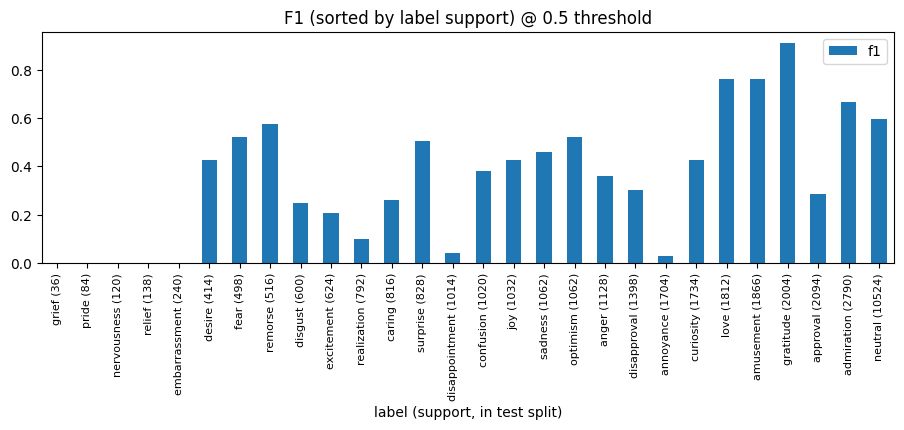

In [18]:
per_label_results["label (support)"] = (
    per_label_results.index + " (" + per_label_results["support"].astype(str) + ")"
)
ax = per_label_results.sort_values(by="support").plot.bar(
    x="label (support)",
    y=["f1"],
    rot=90,
    title="F1 (sorted by label support) @ 0.5 threshold",
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

We can recreate dataset-wide metrics from per-label metrics, which will prove useful later.

In [19]:
def dataset_wide_metrics(df):
    simple_mean = {
        m: round(df[m].mean(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Simple mean of labels:", simple_mean)
    weighted = {
        m: round(sum(df[m] * df["support"]) / df["support"].sum(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Weighted average (using support):", weighted)
    return simple_mean, weighted

_ = dataset_wide_metrics(per_label_results)

Simple mean of labels: {'precision': np.float64(0.5), 'recall': np.float64(0.299), 'f1': np.float64(0.349), 'mcc': np.float64(0.352)}
Weighted average (using support): {'precision': np.float64(0.628), 'recall': np.float64(0.436), 'f1': np.float64(0.489), 'mcc': np.float64(0.449)}


So, now lets do a crude search for how the metrics vary by threshold, rather than naively setting it at 0.5 as above

In [20]:
threshold_results = {}
for t in tqdm(range(5, 100, 5)):
    threshold = t / 100
    y_preds_all = (y_probas_all > threshold).astype(int)
    threshold_results[threshold] = []
    for label_index, label in enumerate(labels):
        y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
        threshold_results[threshold].append(calc_label_metrics(label, y_targets, y_preds, threshold))

100%|██████████| 19/19 [00:08<00:00,  2.17it/s]


In [21]:
metric_name = "f1"
best = {label: {metric_name: -1, "result": None} for label in labels}
for threshold, results in threshold_results.items():
    for result in results:
        label = result["label"]
        if result[metric_name] > best[label][metric_name]:
            best[label] = {metric_name: result[metric_name], "result": result}

results = [b["result"] for b in best.values()]
per_label_threshold_results = pd.DataFrame(results, index=[result["label"] for result in results])
display(per_label_threshold_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.942,0.652,0.684,0.667,0.636,2790,0.40
amusement,0.973,0.735,0.817,0.774,0.760,1866,0.35
anger,0.960,0.411,0.364,0.386,0.366,1128,0.35
annoyance,0.896,0.246,0.481,0.325,0.293,1704,0.15
approval,0.910,0.329,0.383,0.354,0.307,2094,0.20
caring,0.958,0.285,0.460,0.352,0.341,816,0.15
confusion,0.965,0.444,0.401,0.421,0.404,1020,0.25
curiosity,0.935,0.433,0.740,0.546,0.535,1734,0.25
desire,0.984,0.404,0.534,0.460,0.457,414,0.25
disappointment,0.942,0.224,0.345,0.272,0.249,1014,0.15


Charting it

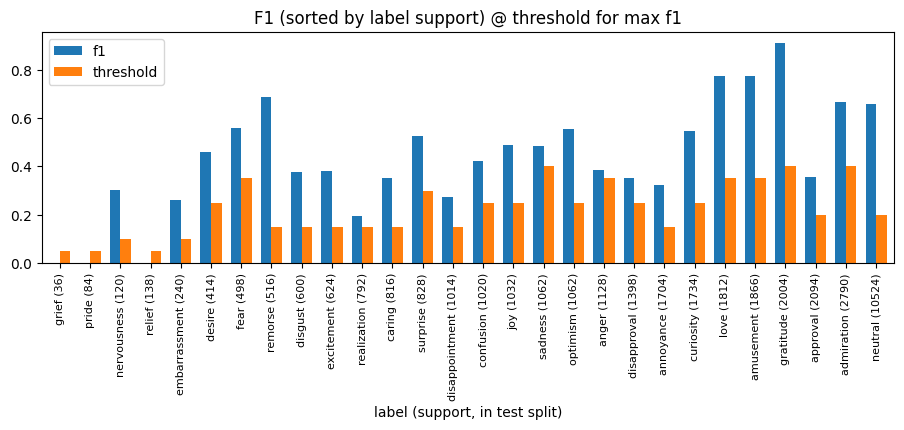

In [22]:
per_label_threshold_results["label (support)"] = (
    per_label_threshold_results["label"] + " (" + per_label_threshold_results["support"].astype(str) + ")"
)
ax = per_label_threshold_results.sort_values(by="support").plot.bar(
    x='label (support)',
    y=["f1", "threshold"],
    rot=90,
    title="F1 (sorted by label support) @ threshold for max f1",
    width=0.7,
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

Note how the best performing threshold (when measured by maximizing f1) is always a lower threshold than the 0.5 assumed before. This is likely because there are so mny true negatives in the dataset (as is often the case with multi-label, multi-class datasets).

As you'd expect precision takes a dip vs before as the model is predicting positive more often, but to a lesser degree than recall climbs, causing F1 to overall increase (since F1 is the harmonic mean of precision and recall).

The most extreme examples being the labels with the smallest support (e.g. grief) where the smallest threshold tried (0.05) is the one that cajoles the model into finally giving some positives and hence getting valid precision and recall scores that can't do if they never predict positive.

Various techniques could be used to increase the probas so these low thresholds were not the best, such as boosting/duplicating the true positives in the training set, data augmentation, or a linear layer to boost the proba output, but simply using a label-bespoke threshold here gives us a view of the perf of the model as it is.

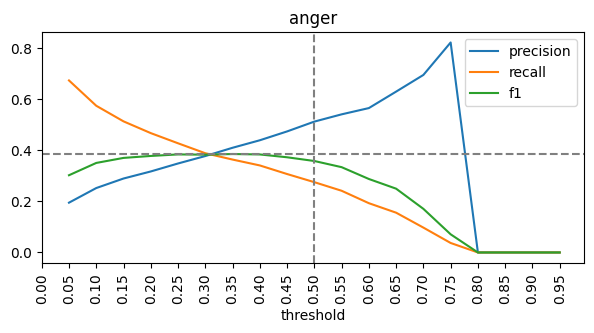

In [23]:
_label_name = "anger"
label_per_threshold_results = []
for threshold, results in threshold_results.items():
    for result in results:
        if result["label"] == _label_name:
            label_per_threshold_results.append(result)

label_per_threshold_results = pd.DataFrame(
    label_per_threshold_results, index=[r["threshold"] for r in label_per_threshold_results]
)
ax = label_per_threshold_results.plot.line(
    x="threshold", y=["precision", "recall", "f1"], rot=90, title=_label_name, figsize=(7,3)
)
ax.axvline(0.5, color='gray', linestyle='--')
ax.axhline(label_per_threshold_results["f1"].max(), color="gray", linestyle="--")
ax.xaxis.set_ticks(np.arange(0, 1, 0.05))
plt.show()

In [24]:
print("### Threshold set to arbitary 0.5")
_before = dataset_wide_metrics(per_label_results)
print()
print("### Threshold from per label search (for best F1 score)")
_after = dataset_wide_metrics(per_label_threshold_results)

print()
percentage = (_after[0]["f1"] - _before[0]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (simple mean) improved by {round(percentage, 1)}%")
percentage = (_after[1]["f1"] - _before[1]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (weighted) improved by {round(percentage, 1)}%")

### Threshold set to arbitary 0.5
Simple mean of labels: {'precision': np.float64(0.5), 'recall': np.float64(0.299), 'f1': np.float64(0.349), 'mcc': np.float64(0.352)}
Weighted average (using support): {'precision': np.float64(0.628), 'recall': np.float64(0.436), 'f1': np.float64(0.489), 'mcc': np.float64(0.449)}

### Threshold from per label search (for best F1 score)
Simple mean of labels: {'precision': np.float64(0.411), 'recall': np.float64(0.467), 'f1': np.float64(0.431), 'mcc': np.float64(0.412)}
Weighted average (using support): {'precision': np.float64(0.511), 'recall': np.float64(0.634), 'f1': np.float64(0.559), 'mcc': np.float64(0.493)}

F1 (simple mean) improved by 23.5%
F1 (weighted) improved by 20.1%


### Dataset constraints on the model performance

Some labels (E.g. gratitude) when considered independently perform very strongly with F1 around 0.9, whilst others (E.g. relief) perform very poorly.

This is a challenging dataset. Labels such as relief do have much fewer examples in the training data (less than 100 out of the 40k+, and only 11 in the test split).

But there is also some ambiguity and/or labelling errors visible in the training data of go_emotions that is suspected to constrain the performance. Data cleaning on the dataset to reduce some of the mistakes, ambiguity, conflicts and duplication in the labelling would produce a higher performing model.